<a href="https://colab.research.google.com/github/halehhajizadeh/PlanckGBM/blob/main/CosmicString.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/My\ Drive/PlanckGBM

/gdrive/My Drive/PlanckGBM


In [ ]:
!pip install healpy

     |████████████████████████████████| 18.1 MB 815 kB/s 


In [ ]:
!pip install git+https://github.com/vafaei-ar/ccgpack.git

  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-9e44p0wm
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-9e44p0wm
  Created wheel for ccgpack: filename=ccgpack-0.1.0-cp37-cp37m-linux_x86_64.whl size=910105 sha256=451429994a3e80f6f8c078d1a3d449496cce5ef99232951706155ce44938a61c
  Stored in directory: /tmp/pip-ephem-wheel-cache-sumzwp2s/wheels/12/6f/95/7ae57565d174cea0e92a0da0a36f289e045f46ef2173da656b
Successfully built ccgpack


In [ ]:
import sys
sys.path.append('/gdrive/My\ Drive/git_reps/ccgpack')

# Importing Libraries


In [ ]:
%matplotlib inline

import os
import sys
import math
import gzip
import shutil
import pickle
import pprint
import random
import urllib
import argparse
import requests
import itertools
import numpy as np
import healpy as hp
import ccgpack as ccg
import xgboost as xgb
import lightgbm as lgb
from healpy import cartview
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
import logging
logging.basicConfig(filename='./info.log', level=logging.DEBUG)

In [ ]:
cmap = plt.cm.jet
cmap.set_under('w')
cmap.set_bad('gray',1.)

# Downloading Cosmic String Map

In [ ]:
def make_directory(directory):
    """make_directory is a function creates a directory if it does not exist.
    Args:
        directory (str): Path to the directory.		

    Returns: None    
    """
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except Exception as e:
            logging.error('Can NOT make directory')
            logging.error(str(e))
    return None  

In [ ]:
import requests
def download_data(url, file_name):
    """download_data is a funtion that download data from a url link and save it in a directory.
    Args:
        url (str): url of the resource to download.
        file_name (str): a name that the downloaded data will save by that.

    Returns: 
        None    
    """
    if file_name is None:
        file_name = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    with open(file_name, 'wb') as f:
        f.write(r.content)  

In [ ]:
def extract(input_file,output_file):
    """extract funtions can take a zipped file and unzip that.
    Args:
        input_file (str):
        output_file (str): 
    """
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [ ]:
make_directory('./data/string/') 

In [ ]:
nside = 2048
l_max = 2*nside
number_string = 1  # The number of string map that we want to download it. 

In [ ]:
for i in range(number_string): 
    os.path.exists('./data/string/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(i+1)+'.fits.gz')
    print('Downloading string: '+str(i))
    download_data('http://cp3.irmp.ucl.ac.be/~ringeval/upload/data/'+str(nside)+'/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(i+1)+'.fits.gz',
    './data/string/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(i+1)+'.fits.gz')
    if not os.path.exists('./data/string/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(i+1)+'.fits'):
        print('Extracting string: '+str(i))
        in_file = './data/string/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(i+1)+'.fits.gz'
        out_file = './data/string/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(i+1)+'.fits'
        extract(in_file,out_file)

Text(0.5, 1.0, 'Cosmic String Map')

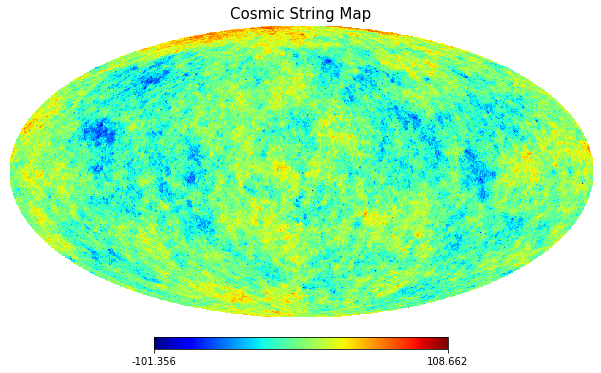

In [ ]:
string_map = hp.read_map('./data/string/map1n_allz_rtaapixlw_'+str(nside)+'_1'+'.fits',nest=1)     
hp.mollview(string_map, cmap=cmap, nest=1)
plt.title('Cosmic String Map', fontsize=15)

# Downloading CMB Simulation map

In [ ]:
make_directory('./data/dx/') 

In [ ]:
number_cmb = 1

In [ ]:
for i in range(number_cmb):
    for map_type in ['cmb','noise']:
        os.path.exists('./data/dx/dx12_v3_smica_{}_mc_0000'+str(i)+'_raw.fits'.format(map_type))
        print('Downloading {} simulation: '.format(map_type))
        download_data('http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=dx12_v3_smica_{}_mc_0000'+str(i)+'_raw.fits'.format(map_type),
                        './data/dx/dx12_v3_smica_{}_mc_0000'+str(i)+'_raw.fits'.format(map_type))
        print('Downloading {} simulation completed '.format(map_type))

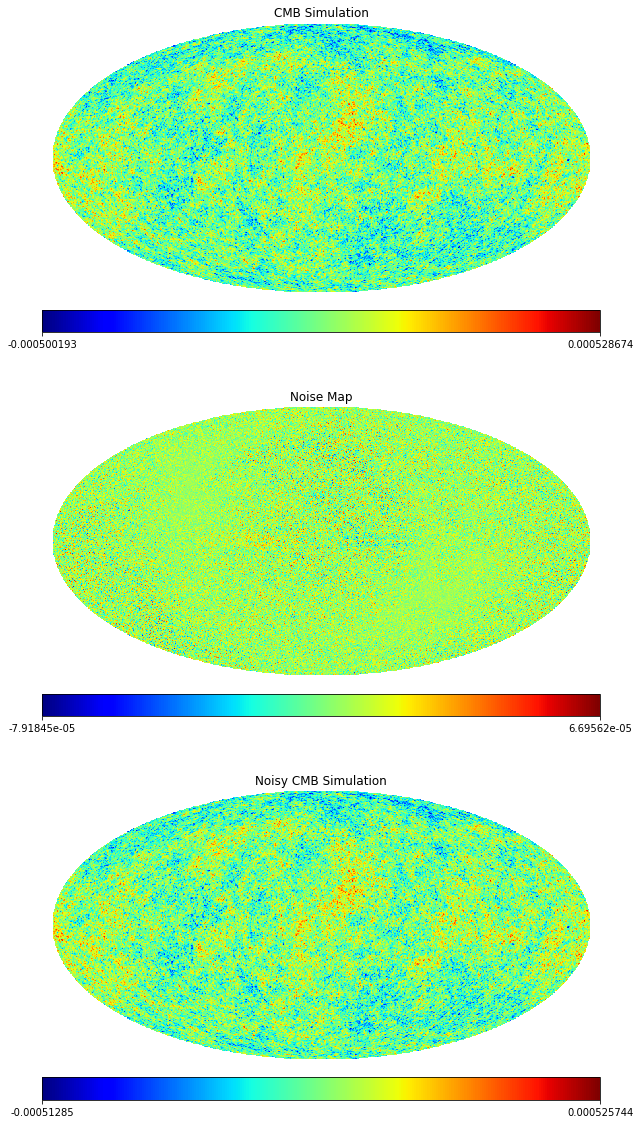

In [ ]:
cmb_map = hp.read_map('./data/dx/dx12_v3_smica_cmb_mc_00000_raw.fits',nest=1)   
noise_map = hp.read_map('./data/dx/dx12_v3_smica_noise_mc_00000_raw.fits',nest=1)   
cmb_map_total = cmb_map + noise_map 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,20))

plt.axes(ax1)
hp.mollview(cmb_map, cmap=cmap, nest=1, hold=True, title='CMB Simulation')  

plt.axes(ax2)
hp.mollview(noise_map, cmap=cmap, nest=1, hold=True, title='Noise Map')  

plt.axes(ax3)
hp.mollview(cmb_map_total, cmap=cmap, nest=1, hold=True, title='Noisy CMB Simulation') 

# Power Spectrum

In [ ]:
cmb_map = hp.read_map('./data/dx/dx12_v3_smica_cmb_mc_00000_raw.fits')  

In [ ]:
nside = 2048

In [ ]:
cl1 = hp.anafast(cmb_map, lmax=3*nside)

In [ ]:
ell1 = np.arange(len(cl1))

In [ ]:
y = ccg.power_spectrum()

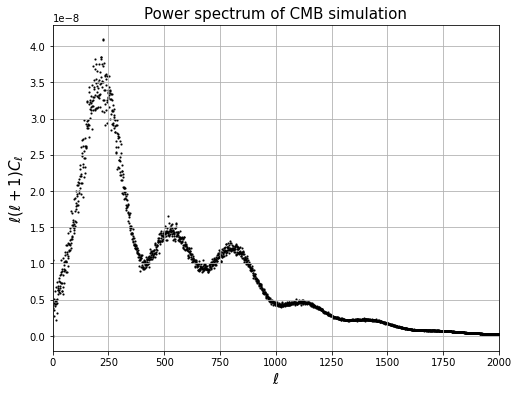

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(ell1, ell1 * (ell1 + 1) * cl1, s=4, c='black', lw=0.1)     
# plt.plot(ell1, ell1 * (ell1 + 1) * cl1, c='red')   
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$\ell(\ell+1)C_\ell$', fontsize=15)
plt.title('Power spectrum of CMB simulation', fontsize=15)
plt.grid()
plt.xlim(0, 2000)
plt.show()

# Dividing Maps to Patches

## Functions

In [ ]:
def kelvin_check(m):
    """
    """
    if m.std()>1e-2:
        m = 1e-6*m
    return m 

In [ ]:

def patch_maker(map_type, number_map, number_patches, nside=2048):
    """
    Args:
        map_type (str): 
        number_map (int):
        number_patches (int): It should be a number that obey this equation: 12*a**2
        nside (int):
    """
    n_patch = np.log2((number_patches/12)) + 1
    n_patch = int(n_patch)
    if map_type == 'cmb' or map_type == 'noise':
        make_directory('./data/dx/'+str(map_type)+'_patches')
        for i in range(number_map):
            map = hp.read_map('./data/dx/dx12_v3_smica_'+str(map_type)+'_mc_0000'+str(i)+'_raw.fits',nest=1)
            map = kelvin_check(map)
            map = ccg.sky2patch(map,int(n_patch))
            for j in range(number_patches):
                print(str(map_type)+'_'+'map number_' + str(i) + '_patch number_' + str(j+1)+' is Done') 
                np.save('./data/dx/'+str(map_type)+'_patches/'+'imap'+str(i)+'_ipatch'+str(j)+'_'+str(nside)+'.npy',map[j])

    elif map_type == 'string':
        for i in range(number_map):
            make_directory('./data/string/'+str(map_type)+'_patches')
            map = hp.read_map('./data/string/map1n_allz_rtaapixlw_'+str(nside)+'_'+str(number_map)+'.fits',nest=1)
            map = kelvin_check(map)
            map = ccg.sky2patch(map,int(n_patch))
            for j in range(number_patches):
                print(str(map_type)+'_'+'map number_' + str(i) + '_patch number_' + str(j+1)+' is Done') 
                np.save('./data/string/'+str(map_type)+'_patches/'+'imap'+str(i)+'_ipatch'+str(j)+'_'+str(nside)+'.npy',map[j])


In [ ]:
patch_maker('string', 1, 12, 2048)

In [ ]:
patch_maker('cmb', 1, 12, 2048)

In [ ]:
patch_maker('noise', 1, 12, 2048)

## Visualizing Patches

In [ ]:
cmb_patch = np.load('./data/dx/cmb_patches/imap0_ipatch11_2048.npy')
noise_patch = np.load('./data/dx/noise_patches/imap0_ipatch11_2048.npy')
string_patch = np.load('./data/string/string_patches/imap0_ipatch11_2048.npy')

(-0.5, 2047.5, 2047.5, -0.5)

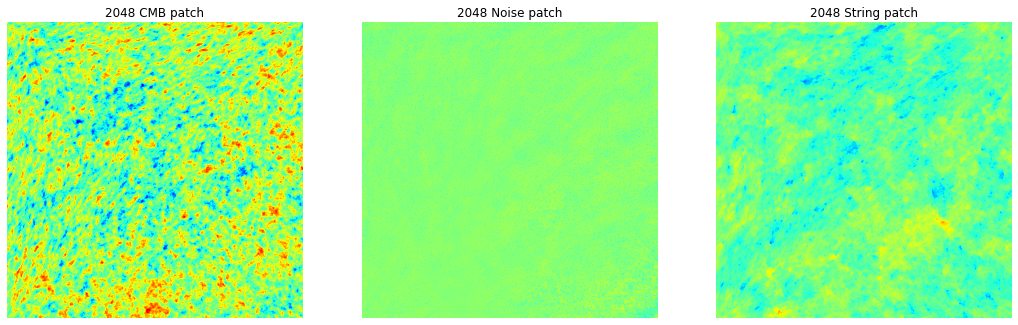

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(18,14))

axs[0].imshow(cmb_patch, cmap ='jet')
axs[0].set_title('2048 CMB patch')
axs[0].axis('off')

axs[1].imshow(noise_patch, cmap ='jet')
axs[1].set_title('2048 Noise patch')
axs[1].axis('off')

axs[2].imshow(string_patch, cmap ='jet')
axs[2].set_title('2048 String patch')
axs[2].axis('off')


## Creating Sub Patches

In [ ]:
def blocker(array, rows_size, columns_size):
    """This function devides a total map to small parts that we call them patches.
    Args:
        array (int):
        rows_number (int):
        columns_number (int):
    """
    h, w = array.shape
    return (array.reshape(h//rows_size, rows_size, -1, columns_size)
               .swapaxes(1,2)
               .reshape(-1, rows_size, columns_size))

In [ ]:
data = {}
patches_paths = ['./data/dx/cmb_patches', './data/dx/noise_patches', './data/string/string_patches/']
map_types = ['cmb', 'noise', 'string']
for path, map_type in zip(patches_paths, map_types):
    for npfile in os.listdir(path):
        xpath = os.path.join(path, npfile)
        arr = np.load(xpath)
        sub_patches = blocker(arr, 256, 256)
        if data.get(npfile.replace("_2048.npy",""), None) is None:
            data[npfile.replace("_2048.npy","")] = {map_type: sub_patches}
        else:
            data[npfile.replace("_2048.npy","")][map_type] = sub_patches

In [ ]:
data.keys()

dict_keys(['imap0_ipatch6', 'imap0_ipatch3', 'imap0_ipatch2', 'imap0_ipatch5', 'imap0_ipatch4', 'imap0_ipatch1', 'imap0_ipatch0', 'imap0_ipatch7', 'imap0_ipatch8', 'imap0_ipatch9', 'imap0_ipatch10', 'imap0_ipatch11'])

In [ ]:
for key, value in data.items():
    data[key]['cmb+noise'] = data[key]['cmb'] + data[key]['noise']

## <h1> Adding G&mu; of Strings <h1>

$\mu$: Linear density of cosmic strings

$G\mu$: Tension of the strings. That is the main parameter that characterizing cosmic strings

$v$: Speed of strings

**Sachs-Wolf effect of cosmic strings:**
$δT/T = 8πG\mu v$


We took tension of cosmic strings in the range of $(6*10^{-9}, 6*10^{-6})$

In [ ]:
gmulist = [0]+list(6*10**np.linspace(-9 , -6 , 10))

In [ ]:
gmulist

[0,
 6.000000000000001e-09,
 1.292660814019132e-08,
 2.7849533001676637e-08,
 6.000000000000001e-08,
 1.2926608140191294e-07,
 2.7849533001676634e-07,
 6e-07,
 1.2926608140191293e-06,
 2.7849533001676634e-06,
 6e-06]

In [ ]:
class_name = ["%.2E" % elem for elem in gmulist]

In [ ]:
class_name

['0.00E+00',
 '6.00E-09',
 '1.29E-08',
 '2.78E-08',
 '6.00E-08',
 '1.29E-07',
 '2.78E-07',
 '6.00E-07',
 '1.29E-06',
 '2.78E-06',
 '6.00E-06']

In [ ]:
for i in range(len(gmulist)):
    for key, value in data.items():
        data[key]['class' + str(i)] = (data[key]['cmb'] + data[key]['noise']) + gmulist[i]*data[key]['string']
    print('class' + ' '+ str(i)+' is Done!')    

In [ ]:
data.keys()

## Visualizing Stringy CMB

In [ ]:
stringy_patch = data['imap0_ipatch0']['cmb+noise'][0] + gmulist[10]*data['imap0_ipatch0']['string'][0]

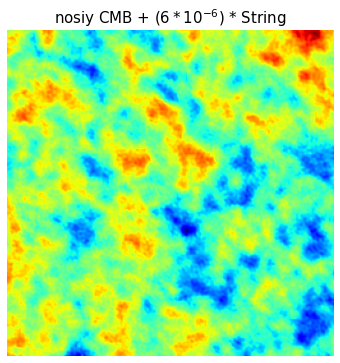

In [ ]:
plt.figure(figsize = (6,6))
plt.imshow(stringy_patch, cmap='jet')
plt.title('nosiy CMB + $(6*10^{-6})$ * String', fontsize = 15)
plt.axis('off')
plt.show()

# Image Processing

## Curvelet Decomposition


In [ ]:
curveleted_stringy_patch = ccg.curvelet(stringy_patch, 3)
curveleted_cmb_patch = ccg.curvelet(data['imap0_ipatch0']['cmb'][0], 3)
curveleted_string_patch = ccg.curvelet(data['imap0_ipatch0']['string'][0], 3)

(-0.5, 255.5, 255.5, -0.5)

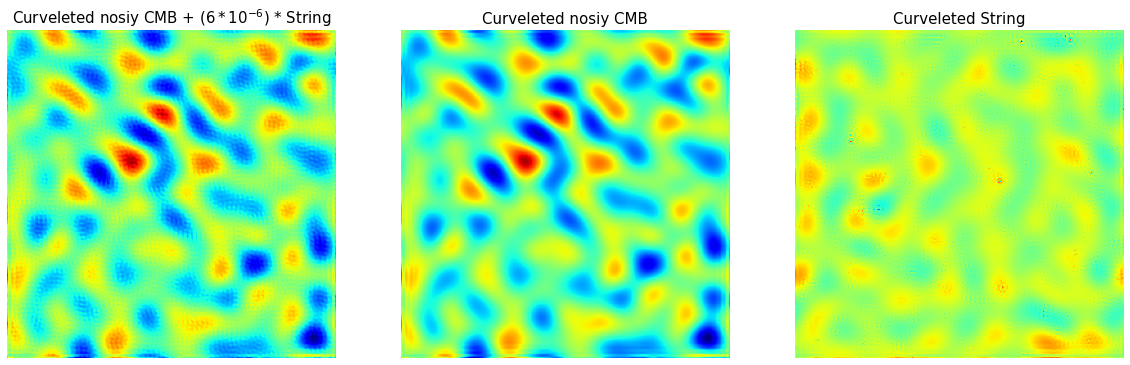

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,15))

axs[0].imshow(curveleted_stringy_patch, cmap='jet')
axs[0].set_title('Curveleted nosiy CMB + $(6*10^{-6})$ * String', fontsize=15)
axs[0].axis('off')

axs[1].imshow(curveleted_cmb_patch, cmap='jet')
axs[1].set_title('Curveleted nosiy CMB', fontsize=15)
axs[1].axis('off')

axs[2].imshow(curveleted_string_patch, cmap='jet')
axs[2].set_title('Curveleted String', fontsize=15)
axs[2].axis('off')  

## Filter (Canny Algoithm)**bold text**

In [ ]:
filtered_stringy_patch = ccg.filters(stringy_patch, 'sob')
filtered_cmb_patch = ccg.filters(data['imap0_ipatch0']['cmb'][0], 'sob')
filtered_string_patch = ccg.filters(data['imap0_ipatch0']['string'][0], 'sob')

(-0.5, 255.5, 255.5, -0.5)

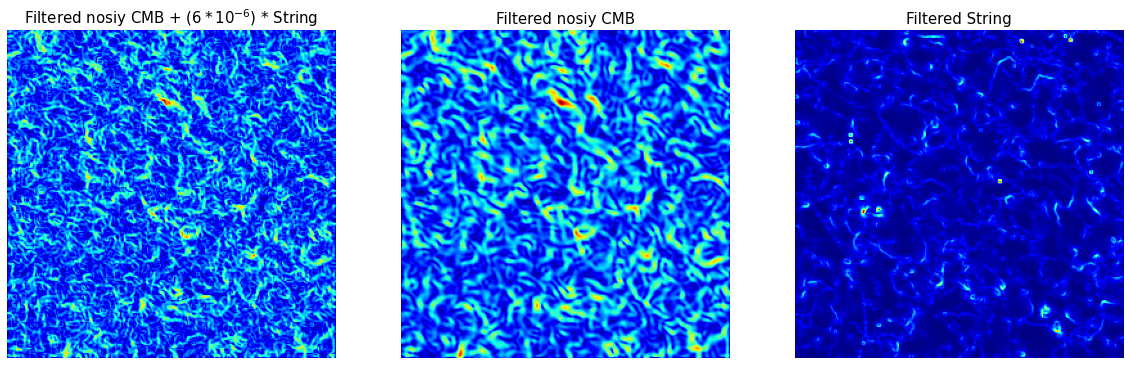

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,15))

axs[0].imshow(filtered_stringy_patch, cmap='jet')
axs[0].set_title('Filtered nosiy CMB + $(6*10^{-6})$ * String', fontsize=15)
axs[0].axis('off')

axs[1].imshow(filtered_cmb_patch, cmap='jet')
axs[1].set_title('Filtered nosiy CMB', fontsize=15)
axs[1].axis('off')

axs[2].imshow(filtered_string_patch, cmap='jet')
axs[2].set_title('Filtered String', fontsize=15)
axs[2].axis('off')   

## Curvelet & Filter

In [ ]:
filtered_curveleted_stringy_patch = ccg.filters(curveleted_stringy_patch, 'sch')
filtered_curveleted_cmb_patch = ccg.filters(curveleted_cmb_patch, 'sch')
filtered_curveleted_string_patch = ccg.filters(curveleted_string_patch, 'sch')

(-0.5, 255.5, 255.5, -0.5)

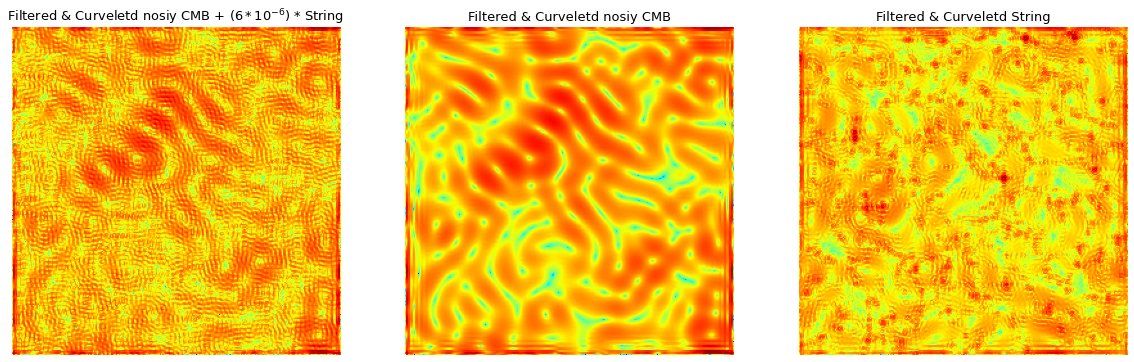

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,15))

axs[0].imshow(filtered_curveleted_stringy_patch, norm=LogNorm(), cmap='jet')
axs[0].set_title('Filtered & Curveletd nosiy CMB + $(6*10^{-6})$ * String', fontsize=13)
axs[0].axis('off')

axs[1].imshow(filtered_curveleted_cmb_patch, norm=LogNorm(), cmap='jet')
axs[1].set_title('Filtered & Curveletd nosiy CMB', fontsize=13)
axs[1].axis('off')

axs[2].imshow(filtered_curveleted_string_patch, norm=LogNorm(), cmap='jet')
axs[2].set_title('Filtered & Curveletd String', fontsize=13)
axs[2].axis('off') 

# Save Data in a Dictionary

In [ ]:
keys_to_remove = ['cmb', 'noise', 'string', 'cmb+noise']
for key, value in data.items():
    for k in keys_to_remove:
        data[key].pop(k)

In [ ]:
data.keys()

dict_keys(['imap0_ipatch6', 'imap0_ipatch3', 'imap0_ipatch2', 'imap0_ipatch5', 'imap0_ipatch4', 'imap0_ipatch1', 'imap0_ipatch0', 'imap0_ipatch7', 'imap0_ipatch8', 'imap0_ipatch9', 'imap0_ipatch10', 'imap0_ipatch11'])

In [ ]:
for class_name in range(len(gmulist)):
    for key, value in data.items():
        data[key]['class'+str(class_name)] = data[key]['class'+str(class_name)][:5]

In [ ]:
data.keys()

dict_keys(['imap0_ipatch6', 'imap0_ipatch3', 'imap0_ipatch2', 'imap0_ipatch5', 'imap0_ipatch4', 'imap0_ipatch1', 'imap0_ipatch0', 'imap0_ipatch7', 'imap0_ipatch8', 'imap0_ipatch9', 'imap0_ipatch10', 'imap0_ipatch11'])

In [ ]:
data['imap0_ipatch0']['class0'].shape

(5, 256, 256)

In [ ]:
file_to_write = open("./data/results/dictionary_gmu.pickle", "wb")

pickle.dump(data, file_to_write)

# Applying Image Processing on Patches

In [ ]:
data = open("./data/results/dictionary_gmu.pickle", "rb")
data = pickle.load(data)

In [ ]:
data['imap0_ipatch0']['class0'].shape

(5, 256, 256)

In [ ]:
for class_index in range(len(gmulist)):
    for component_curvelet in range(5,8):
        for type_filter in ['sch', 'sob']:
            for key, value in data.items():
                curveleted = ccg.curvelet(data[key]['class'+str(class_index)], component_curvelet)
                filtered = ccg.filters(curveleted, type_filter)
                # print('key: ' + str(key) + ', ' + 'curvelet: ' + str(component_curvelet) + ', ' + 'filter: ' + str(type_filter) + ', ' + 'class: ' + str(class_index) + ' is Done!')
                data[key]['class' + str(class_index) + '_' + 'c' + str(component_curvelet) + '_' + str(type_filter)] = filtered

In [ ]:
for class_index in range(len(gmulist)):
    for key, value in data.items():
            data[key].pop('class'+str(class_index))

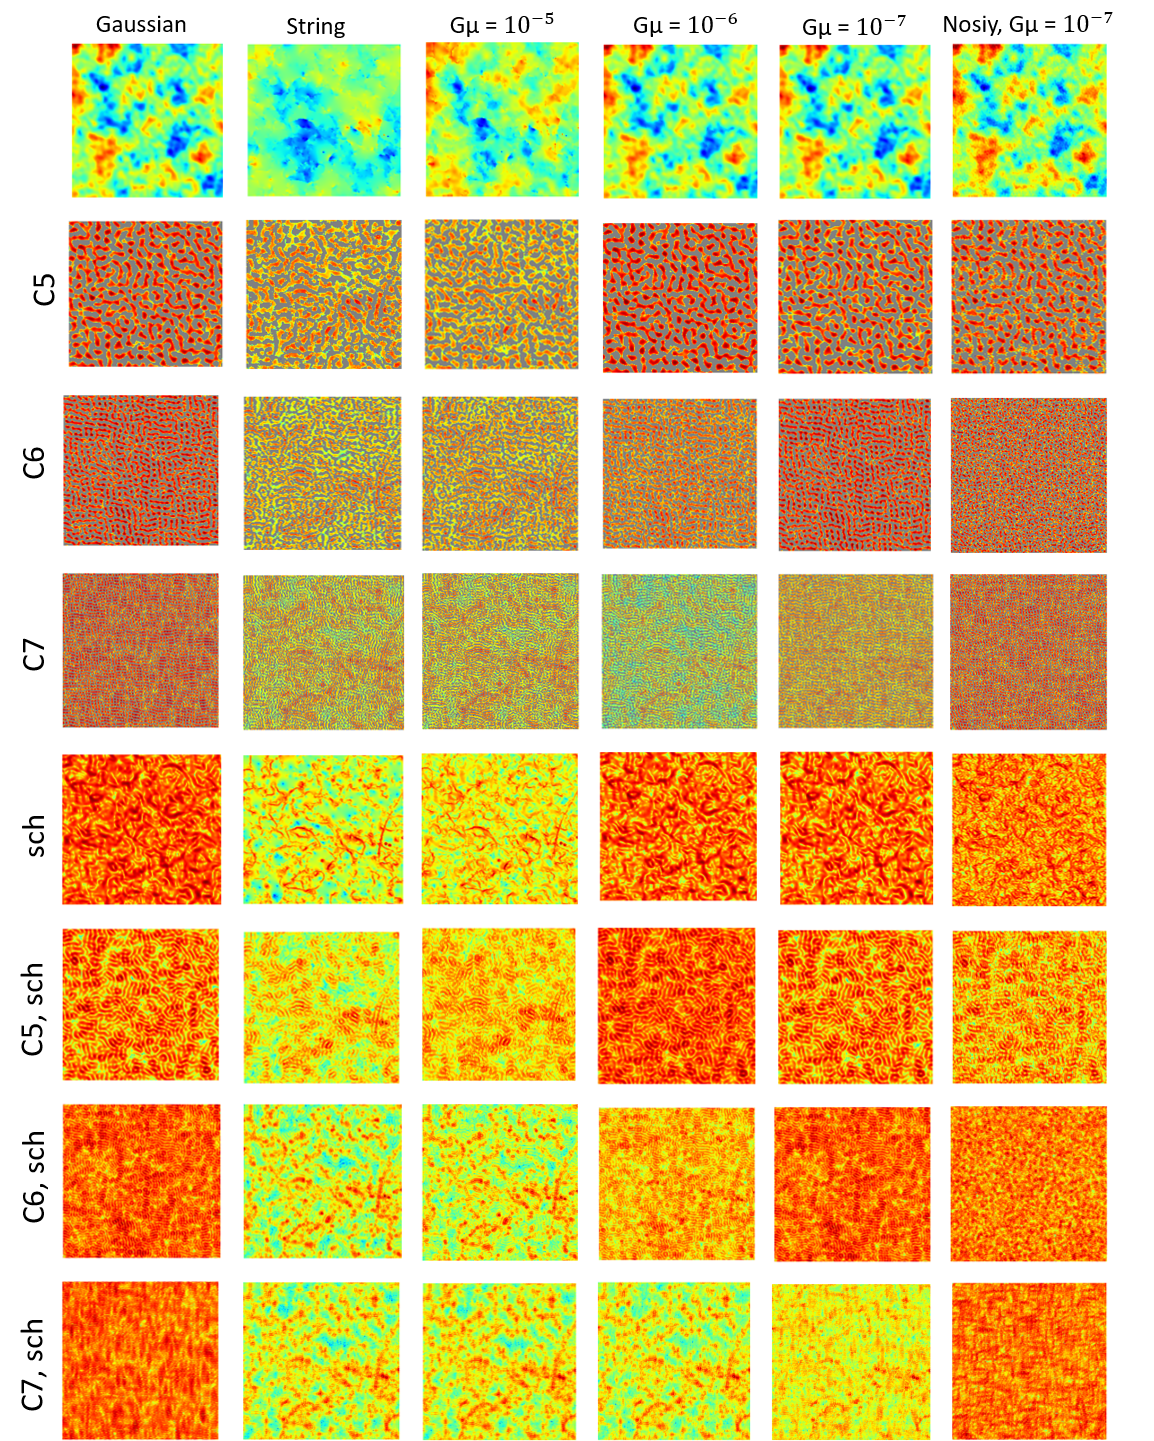

# Statistical Calculations

In [ ]:
def pdf(m,bins=20,normed=None):
    m = np.array(m)
    hist, bin_edges = np.histogram(m, bins, density=normed)
    bins = 0.5*(bin_edges[1:]+bin_edges[:-1])
    return bins,hist

In [ ]:
def interp(xs, xp, fp):
    ys  = []
    xmin = np.min(xp)
    xmax = np.max(xp)
    for x in xs:
        if x>xmin and x<xmax:
            y = np.interp(x, xp, fp)
        else:
            y = 0
        ys.append(y)
    return np.array(ys)

In [ ]:
def delta_pdf(pdf1,pdf2):
    bins1,hist1 = pdf1
    bins2,hist2 = pdf2
    
    xmin = np.min([np.min(bins1),np.min(bins2)])
    xmax = np.min([np.max(bins1),np.max(bins2)])
    xs = np.linspace(xmin,xmax,200)
    
    h1 = interp(xs, bins1,hist1)
    h2 = interp(xs, bins2,hist2)

    delta = np.sum((h1-h2)**2)*(xs[1]-xs[0])

    return delta

In [ ]:
stat_name_1 = 'std'
stat_name_2 = 'pdf'

stat_tool_1 = np.std
def stat_tool_2(m):
    m = m.reshape(-1)
    bins, hist = pdf(m,bins=100)
    return [bins,hist]

In [ ]:
data = open("./data/results/dictionary_curveleted_filtered.pickle", "rb")
data = pickle.load(data)

In [ ]:
data['imap0_ipatch0']['class0_c5_sch'].shape

(5, 256, 256)

## Baseline

In [ ]:
baseline_initial = {}
for component_curvelet in range(5,8):
    for type_filter in ['sch', 'sob']:
        std_value = []
        pdf_value = []
        for i in range(12):
            for patch_index in range(5):
                std_value.append(stat_tool_1(data['imap0_ipatch' + str(i)]['class0_' + 'c' + str(component_curvelet) + '_' + str(type_filter)][patch_index]))
                pdf_value.append(stat_tool_2(data['imap0_ipatch' + str(i)]['class0_' + 'c' + str(component_curvelet) + '_' + str(type_filter)][patch_index]))
        baseline_initial.update({'c' + str(component_curvelet) + '_' + str(type_filter) + '_' + 'std' : std_value})
        baseline_initial.update({'c' + str(component_curvelet) + '_' + str(type_filter) + '_' + 'pdf' : pdf_value})

In [ ]:
len(baseline_initial['c5_sch_std'])

60

In [ ]:
baseline = {}
for key, value in baseline_initial.items():
    baseline[key] = np.mean(baseline_initial[key], axis=0)

In [ ]:
baseline.keys()

dict_keys(['c5_sch_std', 'c5_sch_pdf', 'c5_sob_std', 'c5_sob_pdf', 'c6_sch_std', 'c6_sch_pdf', 'c6_sob_std', 'c6_sob_pdf', 'c7_sch_std', 'c7_sch_pdf', 'c7_sob_std', 'c7_sob_pdf'])

In [ ]:
baseline['c6_sch_std']

0.0009185135312589531

### Save Baseline

In [ ]:
file_to_write = open("./data/results/baseline.pickle", "wb")

pickle.dump(data, file_to_write)

## Calculations

In [ ]:
for component_curvelet in range(5,8):
    for type_filter in ['sch', 'sob']:

In [ ]:
features = [[] for i in gmulist]
for i_map in range(100):
    for i_srg in range(3):
        for i_patch in range(12):
#            for i_stch in range(12):
            i_stch = i_patch
            fname = add+'m{}_s{}_im{}_is{}'.format(i_map,i_srg,i_patch,i_stch)
            res = load(fname)
            for i in range(npp):
                for i_gm in range(ngmu):
                    
                    keyn = 'g{}_i{}_c{}'.format(i_gm,i,rs)
                    sob_std = res[keyn+'_sob_'+sname1]
                    sob_pdf = res[keyn+'_sob_'+sname2]
                    sch_std = res[keyn+'_sch_'+sname1]
                    sch_pdf = res[keyn+'_sch_'+sname2]

                    delta1 = (sob_std-sob_std0s)**2
                    delta2 = (sch_std-sch_std0s)**2
                    
                    delta3 = delta_pdf(sob_pdf,sob_pdf0s)
                    delta4 = delta_pdf(sch_pdf,sch_pdf0s)

                    features[i_gm].append([delta1,delta2,delta3,delta4])

save('res_'+str(rs),features)

# Machine Learning

## LightGBM

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.gca().invert_yaxis()

    plt.title(title,fontsize = 15)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
    plt.tight_layout()

## Splitting data to train and test sets

In [ ]:
map_name = 'noisy SMICA-Separated FFP10'

res5 = open('./data/'+map_name+'/res_5.pickle',"rb")
res6 = open('./data/'+map_name+'/res_6.pickle',"rb")
res7 = open('./data/'+map_name+'/res_7.pickle',"rb")
res5 = pickle.load(res5)
res6 = pickle.load(res6)
res7 = pickle.load(res7)

In [ ]:
res5 = np.array(res5)
res6 = np.array(res6)
res7 = np.array(res7)

In [ ]:
results = np.concatenate((res5,res6,res7), axis=2, out=None)

In [ ]:
results_shape = results.shape[1]

In [ ]:
y = np.zeros((len(gmulist),results_shape))
for i in range(len(gmulist)):
    y[i,:] = int(i)

In [ ]:
X = results.reshape(-1,12)
Y = y.reshape(-1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=20)

In [ ]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'num_class':11 ,
    'objective': 'multiclass',
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 400,
    'learning_rate': 0.99,
    'num_leaves': 50,
    'n_estimators': 60,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 124,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    # parameters to keep the exactly the same
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.01,
    'colsample_bytree': 0.5,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'max_depth': 7 
}

In [ ]:
clf = lgb.LGBMClassifier(**lgb_params)

In [ ]:
clf.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, colsample_bytree=0.5,
               feature_fraction=0.8, is_enable_sparse=True,
               is_save_binary_file=False, is_training_metric=True,
               learning_rate=0.99, local_listen_port=124,
               machine_list_file='mlist.txt', max_bin=400, max_depth=7,
               metric_freq=1, min_data_in_leaf=50, min_split_gain=0.01,
               min_sum_hessian_in_leaf=5, n_estimators=60, num_class=11,
               num_leaves=50, num_machines=1, objective='multiclass',
               output_model='LightGBM_model.txt', task='train',
               tree_learner='serial', use_two_round_loading=False, verbose=0)

In [ ]:
y_prediction = clf.predict(x_test)

In [ ]:
y_prediction_train = clf.predict(x_train)

Normalized confusion matrix


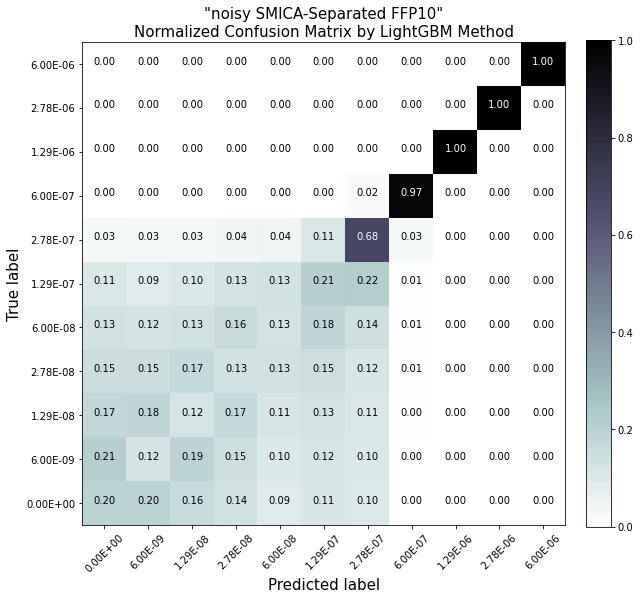

In [ ]:
cnf_matrix = confusion_matrix(y_test,y_prediction)
np.set_printoptions(precision=2)

plt.figure(figsize=(9,9))
foo = plot_confusion_matrix(cnf_matrix, classes=class_name,normalize=True
                      ,cmap = plt.cm.bone_r,title='"'+str(map_name)+'"' +'\n'+'Normalized Confusion Matrix by LightGBM Method')


# XGBoost

In [ ]:
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 11}  # the number of classes that exist in this datset
num_round = 100 # the number of training iterations

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
clf = xgb.train(param, dtrain, num_round)

In [ ]:
y_prediction = clf.predict(dtest)

In [ ]:
best_preds = np.asarray([np.argmax(line) for line in y_prediction])

Normalized confusion matrix


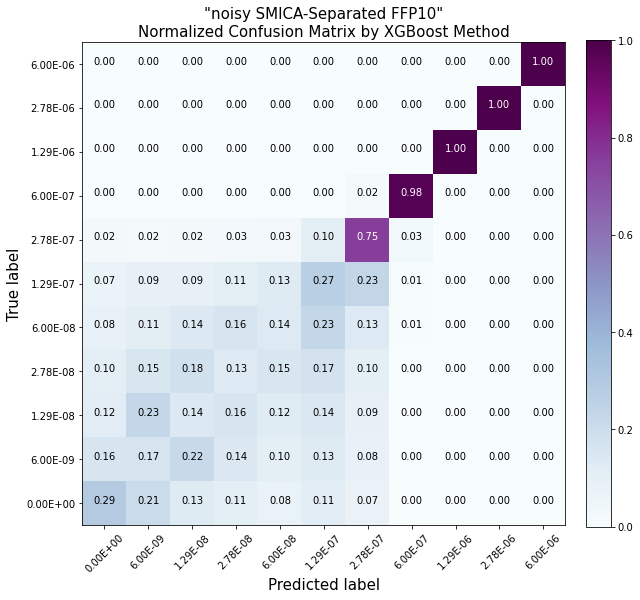

In [ ]:
cnf_matrix = confusion_matrix(y_test,best_preds)
np.set_printoptions(precision=2)

plt.figure(figsize=(9,9))
foo = plot_confusion_matrix(cnf_matrix, classes=class_name,normalize=True
                      ,cmap = plt.cm.BuPu,title='"'+str(map_name)+'"' +'\n'+'Normalized Confusion Matrix by XGBoost Method')